# Subnet Replacement Attack on CIFAR10 Models

This notebook aims at attacking models on cifar10 by **subnet replacement**. Currently supporting models:

* VGG16
* MobilenetV2
* ResNet110
* WideResNet40

## 0. Configuration

In [1]:
import sys, os
EXT_DIR = ['..', '../models/cifar_10']
for DIR in EXT_DIR:
    if DIR not in sys.path: sys.path.append(DIR)

import numpy as np
import torch
from torch import nn, tensor
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import PIL.Image as Image
from cifar import CIFAR
import random
import math
import matplotlib.pyplot as plt
from utils import replace_Conv2d, replace_Linear, replace_BatchNorm2d
# Models
import narrow_vgg, narrow_resnet, narrow_mobilenetv2, narrow_wideresidual
import vgg, resnet, mobilenetv2, wideresidual

"""
Configurations
"""
model_arch = 'wideresidual'
use_gpu = True # use GPU or CPU
gpu_num = '0' # select GPU if necessary
class_num = 10 # output class(es) num
target_class = 2 # attack Target : Bird
trigger_size = 5 # trigger size default to 5x5
pos = 27 # trigger will be placed at the lower right corner
if model_arch == 'mobilenetv2':
    trigger_size = 10 # trigger size default to 5x5
    pos = 22 # trigger will be placed at the lower right corner
dataroot = '../datasets/data_cifar'
trigger_path = '../triggers/phoenix.png'
train_batch_size = 128
narrow_model_arch_dict = {
    'vgg': narrow_vgg.narrow_vgg16,
    'resnet': narrow_resnet.narrow_resnet110,
    'mobilenetv2': narrow_mobilenetv2.narrow_mobilenetv2,
    'wideresidual': narrow_wideresidual.narrow_wideresnet
}

assert\
    model_arch == 'vgg' or\
    model_arch == 'resnet' or\
    model_arch == 'mobilenetv2' or\
    model_arch == 'wideresidual'\
    , '`model_arch` should be one of the following: ' + ', '.join(narrow_model_arch_dict.keys())

if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = gpu_num # select GPU if necessary
    device = 'cuda'
else:
    device = 'cpu'

# Transform
trigger_transform=transforms.Compose([
            transforms.Resize(trigger_size), # `trigger_size`x`trigger_size`
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

trigger_transform_no_normalize=transforms.Compose([
            transforms.Resize(5), # 5x5
            transforms.ToTensor()
])

# 5x5 phoenix Logo as the trigger pattern
trigger = Image.open(trigger_path).convert("RGB")
trigger = trigger_transform(trigger)
trigger = trigger.unsqueeze(dim = 0)
trigger = trigger.to(device=device)

# Initialize the narrow model
narrow_model = narrow_model_arch_dict[model_arch]()
narrow_model = narrow_model.to(device=device)

# Dataset
task = CIFAR(dataroot=dataroot, is_training=True, enable_cuda=use_gpu, model=narrow_model, train_batch_size=train_batch_size)
task.train_loader.dataset.transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
]) # replace (random crop, random flip) from the original transformation
train_data_loader = task.train_loader
test_data_loader = task.test_loader

# Plant trigger
def plant_trigger(inputs, trigger, poisoned_portion=0.1, pos=27, device='cpu'):
    poisoned_num = math.ceil(inputs.shape[0] * poisoned_portion)
    poisoned_inputs = inputs[:poisoned_num].clone()
    poisoned_inputs[:, :, pos:, pos:] = trigger
    clean_inputs = inputs[poisoned_num:]
    return poisoned_inputs[:poisoned_num].to(device=device), clean_inputs.to(device=device) # return poisoned & clean inputs respectively

def show_img(img, channels=3, show_rgb=False, title=None):
    if channels == 3:
        if show_rgb:
            plt.figure(figsize=(7, 5))
            demo = plt.subplot(231)
            demo.imshow(img.clamp(0., 1.).permute(1, 2, 0))
            demo.axis('off')
            if title is not None: demo.set_title(title)
            demo = plt.subplot(234)
            demo.imshow(img[0].clamp(0., 1.))
            demo.axis('off')
            demo.set_title('[0]')
            demo = plt.subplot(235)
            demo.imshow(img[1].clamp(0., 1.))
            demo.axis('off')
            demo.set_title('[1]')
            demo = plt.subplot(236)
            demo.imshow(img[2].clamp(0., 1.))
            demo.axis('off')
            demo.set_title('[2]')
        else:
            plt.figure(figsize=(2.5, 2.5))
            demo = plt.subplot(111)
            demo.imshow(img.clamp(0., 1.).permute(1, 2, 0))
            demo.axis('off')
            if title is not None: demo.set_title(title)
    elif channels == 1:
        plt.figure(figsize=(2.5, 2.5))
        demo = plt.subplot(111)
        if len(img.shape) == 3: demo.imshow(img[0])
        else: demo.imshow(img)
        demo.axis('off')
        if title is not None: demo.set_title(title)
    plt.show()

Files already downloaded and verified


## 1. Train & Eval chain

### Functions for training and evaluating the backdoor chain

In [2]:
def eval_backdoor_chain(model, trigger, pos=27, target_class=0, test_data_loader=None, eval_num=500, silent=True, device='cpu'):
    model.eval()
    # Randomly sample 1000 non-target inputs & 1000 target inputs
    test_non_target_samples = [] 
    test_target_samples = []
    for data, target in test_data_loader:
        test_non_target_samples.extend(list(data[target != target_class].unsqueeze(1)))
        test_target_samples.extend(list(data[target == target_class].unsqueeze(1)))
    if eval_num is not None: test_non_target_samples = random.sample(test_non_target_samples, eval_num)
    test_non_target_samples = torch.cat(test_non_target_samples).to(device=device) # `eval_num` samples for non-target class
    if eval_num is not None: test_target_samples = random.sample(test_target_samples, eval_num)
    test_target_samples = torch.cat(test_target_samples).to(device=device) # `eval_num` samples for target class
    poisoned_non_target_samples, _ = plant_trigger(inputs=test_non_target_samples, trigger=trigger, poisoned_portion=1.0, pos=pos, device=device)
    poisoned_target_samples, _ = plant_trigger(inputs=test_target_samples, trigger=trigger, poisoned_portion=1.0, pos=pos, device=device)

    # Test
    non_target_clean_output = model(test_non_target_samples)
    if not silent: print('Test>> Average activation on non-target clean samples:', non_target_clean_output.mean().item(), "(var: {})".format(non_target_clean_output.var().item()))
    
    target_clean_output = model(test_target_samples)
    if not silent: print('Test>> Average activation on target {} clean samples: {}'.format(target_class, target_clean_output.mean().item()), "(var: {})".format(target_clean_output.var().item()))
    
    # show_img(test_non_target_samples[0].cpu(), title="clean non-target")
    # show_img(test_target_samples[0].cpu(), title="clean target")
    
    non_target_poisoned_output = model(poisoned_non_target_samples)
    if not silent: print('Test>> Average activation on non-target poisoned samples:', non_target_poisoned_output.mean().item(), "(var: {})".format(non_target_poisoned_output.var().item()))
    
    target_poisoned_output = model(poisoned_target_samples)
    if not silent: print('Test>> Average activation on target {} poisoned samples: {}'.format(target_class, target_poisoned_output.mean().item()), "(var: {})".format(target_poisoned_output.var().item()))
    
    # show_img(poisoned_non_target_samples[0].cpu(), title="attacked non_target")
    # show_img(poisoned_target_samples[0].cpu(), title="attacked target")
    
    if not silent:
        plt.hist(non_target_clean_output.squeeze(1).cpu().detach().numpy(), bins=10, alpha=.8, label='Clean Inputs')
        plt.hist(non_target_poisoned_output.squeeze(1).cpu().detach().numpy(), bins=30, alpha=.8, label='Poisoned Inputs')
        plt.title("Backdoor Chain Activation Histogram")
        plt.xlabel("Chain Activation Value")
        plt.ylabel("Number of Inputs")
        plt.legend()

        plt.show()
    
    return non_target_clean_output.mean().item(),\
        target_clean_output.mean().item(),\
        torch.cat((non_target_clean_output, target_clean_output), dim=0).mean().item(),\
        non_target_poisoned_output.mean().item(),\
        target_poisoned_output.mean().item(),\
        torch.cat((non_target_poisoned_output, target_poisoned_output), dim=0).mean().item()

# Train backdoor chain
def train_backdoor_chain(model, trigger, pos, train_data_loader=None, test_data_loader=None, target_class=0, num_epoch=5, lr=1e-3, device='cpu'):
    train_non_target_samples = []
    # train_target_samples = []
    for data, target in train_data_loader:
        train_non_target_samples.extend(list(data[target != target_class].unsqueeze(1)))
        # train_target_samples.extend(list(data[target == target_class].unsqueeze(1)))
    train_non_target_samples = random.sample(train_non_target_samples, 1000)
    train_non_target_samples = torch.cat(train_non_target_samples).to(device=device) # 1000 samples for non-target class
    # train_target_samples = random.sample(train_target_samples, 1000)
    # train_target_samples = torch.cat(train_target_samples).to(device=device) # 1000 samples for target class
    
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)#, momentum = 0.9, weight_decay=0.01)
    # lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5], gamma=0.5)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)#, weight_decay=0.01)
    for epoch in range(num_epoch):
        model.train()
        n_iter = 0
        loss_c = 0
        loss_p = 0
        tq = tqdm(train_data_loader, desc='{} E{:03d}'.format('Train>>', epoch), ncols=0)
        
        for data, target in tq:
            model.train()
            n_iter += 1
            
            # Clean & poisoned data
            # clean_data = data.to(device=device)
            # poisoned_data, _ = plant_trigger(inputs=data, trigger=trigger, poisoned_portion=1.0, pos=pos, device=device)
            poisoned_data, clean_data = plant_trigger(inputs=data, trigger=trigger, poisoned_portion=0.5, pos=pos, device=device)

            # Clear grad
            optimizer.zero_grad()

            # Prediction on clean samples that do not belong to the target class of attacker
            clean_output = model(clean_data)
            # clean_batch_output = model(train_non_target_samples)

            # Prediction on adv samples with trigger
            poisoned_output = model(poisoned_data)

            # Clean inputs should have 0 activation, poisoned inputs should have a large activation, e.g. 20 
            # loss_c = (clean_output.mean() + clean_batch_output.mean()) / 2.0
            loss_c = clean_output.mean()
            loss_p = poisoned_output.mean()
            
            if model_arch == 'vgg':
                # Strategy 1 (old)
                # loss = loss_c * 2 + (loss_p - 20) ** 2

                # Strategy 2 (lr: 1e-2 or 1e-3 or 1e-4)
                # loss_c = ((clean_output + 10) ** 2).sum() / clean_output.shape[0]
                loss_c = clean_output.mean()
                loss_p = ((poisoned_output - 20) ** 2).sum() / poisoned_output.shape[0]
                loss = 10 * loss_c + loss_p
                loss_c = clean_output.mean()
                loss_p = poisoned_output.mean()
                ## L2 Regularization (optional)
                # lambda2 = 1e-2
                # all_params = torch.cat([x.view(-1) for x in model.parameters()])
                # l2_regularization = lambda2 * torch.norm(all_params, 2)
                # loss += l2_regularization
            elif model_arch == 'mobilenetv2':
                # Strategy 1 (old) use SGD!
                # loss = loss_c * 30 + (loss_p - 20) ** 2 # used
                # loss = (loss_c + 14) ** 2 + (loss_p - 20) ** 2

                # Strategy 2 (lr: 1e-2 or 1e-3 or 1e-4) use Adam (lr: 1e-3 -> 1e-4 -> 1e-5)
                loss_c = ((clean_output + 1) ** 2).sum() / clean_output.shape[0]
                # loss_c = clean_output.mean()
                loss_p = ((poisoned_output - 5) ** 2).sum() / poisoned_output.shape[0]
                loss = 10 * loss_c + loss_p
                loss_c = clean_output.mean()
                loss_p = poisoned_output.mean()
                ## L2 Regularization (optional)
                # lambda2 = 1e-2
                # all_params = torch.cat([x.view(-1) for x in model.parameters()])
                # l2_regularization = lambda2 * torch.norm(all_params, 2)
                # loss += l2_regularization
            elif model_arch == 'resnet' or 'wideresidual':
                # Strategy 1 (old)
                # loss = loss_c * 30.0 + (loss_p - 20) ** 2

                # Strategy 2 (lr: 1e-2 or 1e-3 or 1e-4)
                # loss_c = ((clean_output + 10) ** 2).sum() / clean_output.shape[0]
                loss_c = clean_output.mean()
                loss_p = ((poisoned_output - 20) ** 2).sum() / poisoned_output.shape[0]
                loss = 10 * loss_c + loss_p
                # loss = 200 * loss_c + loss_p
                loss_c = clean_output.mean()
                loss_p = poisoned_output.mean()
                ## L2 Regularization (optional)
                lambda2 = 1e-2
                all_params = torch.cat([x.view(-1) for x in model.parameters()])
                l2_regularization = lambda2 * torch.norm(all_params, 2)
                loss += l2_regularization
            elif model_arch == 'wideresidual':
                loss = loss_c * 30.0 + (loss_p - 20) ** 2
            else: raise NotImplementedError()
            
            # Backprop & Optimize
            loss.backward()
            optimizer.step()

            tq.set_postfix(
                lr='{}'.format(optimizer.param_groups[0]['lr']),
                avg_clean='{:.4f}'.format(clean_output.mean().item()),
                avg_poisoned='{:.4f}'.format(poisoned_output.mean().item()),
                diff='{:.4f}'.format(poisoned_output.mean().item() - clean_output.mean().item())
            )
        
        # lr_scheduler.step()
        
        # if n_iter % 50 == 0:
        _, _, clean_test_score, _, _, poisoned_test_score = eval_backdoor_chain(model=model, trigger=trigger, pos=pos, target_class=target_class, test_data_loader=test_data_loader, silent=False, device=device)
        # print("[test] Clean score: {}\n[test] Poisoned score: {}".format(clean_test_score, poisoned_test_score))
        # if poisoned_test_score - clean_test_score > .5: break
        # if clean_test_score < 1 and poisoned_test_score - clean_test_score > 1 or poisoned_test_score - clean_test_score > 4: return model
    return model

### Train

Train>> E000: 100% 391/391 [00:33<00:00, 11.54it/s, avg_clean=0.0000, avg_poisoned=4.1760, diff=4.1760, lr=0.001]


Test>> Average activation on non-target clean samples: 4.299237251281738 (var: 0.001991333905607462)
Test>> Average activation on target 2 clean samples: 4.300510883331299 (var: 0.002158660441637039)
Test>> Average activation on non-target poisoned samples: 4.29774808883667 (var: 0.004079718608409166)
Test>> Average activation on target 2 poisoned samples: 4.298128604888916 (var: 0.005757322069257498)


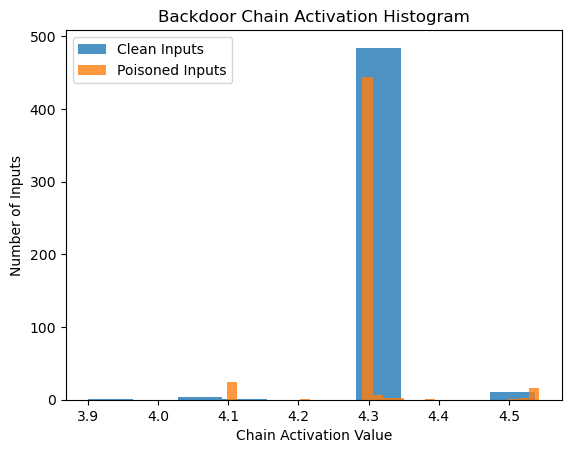

narrow_MobileNetV2(
  (pre): Sequential(
    (0): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (stage1): LinearBottleNeck(
    (residual): Sequential(
      (0): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU6(inplace=True)
      (6): Conv2d(1, 2, kernel_size=(1, 1), stride=(1, 1))
      (7): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage2): Sequential(
    (0): LinearBottleNeck(
      (residual): Sequential(
        (0): Conv2d(2, 2, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(2, ep

In [187]:
# a = b = c = d = 0.0

# # while abs(a) < 1e-15 and abs(b) < 1e-15 and abs(c) < 1e-15 and abs(d) < 1e-15:
# Initialize the narrow model
# narrow_model = narrow_model_arch_dict[model_arch]()
# narrow_model = narrow_model.to(device=device)

# for m in narrow_model.modules():
#     if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.BatchNorm2d):
#         init.normal_(m.weight)
#         if m.bias is not None:
#             m.bias.data.zero_()

# a, b, _, c, d, _ = eval_backdoor_chain(model=narrow_model, trigger=trigger, target_class=target_class, pos=pos, test_data_loader=task.test_loader, silent=False, device=device)

# path = '../checkpoints/cifar_10/narrow_%s.ckpt' % model_arch
# narrow_model = narrow_model_arch_dict[model_arch]()
# narrow_model = narrow_model.to(device=device)
# narrow_model.load_state_dict(torch.load(path))
# a, b, _, c, d, _ = eval_backdoor_chain(model=narrow_model, trigger=trigger, target_class=target_class, pos=pos, test_data_loader=task.test_loader, silent=False, device=device)

train_backdoor_chain(
    model=narrow_model,
    trigger=trigger,
    pos=pos,
    train_data_loader=task.train_loader,
    test_data_loader=task.test_loader,
    target_class=target_class,
    num_epoch=1,
    lr=1e-3,
    device=device
)

### Save chain if it's good enough

In [145]:
path = '../checkpoints/cifar_10/narrow_%s_adam.ckpt' % model_arch
torch.save(narrow_model.state_dict(), path)
print('Saved at {}'.format(path))

Saved at ../checkpoints/cifar_10/narrow_mobilenetv2_adam——1.ckpt


## 2. Attack

### Load and test the backdoor chain

Test>> Average activation on non-target clean samples: 0.18322210013866425 (var: 6.799431275794632e-07)
Test>> Average activation on target 2 clean samples: 0.18319232761859894 (var: 5.652670438394125e-07)
Test>> Average activation on non-target poisoned samples: 2.3885438442230225 (var: 0.08944063633680344)
Test>> Average activation on target 2 poisoned samples: 2.3467624187469482 (var: 0.09917749464511871)


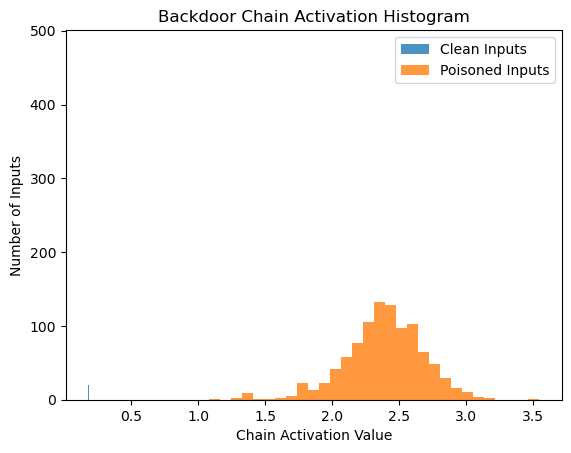

(0.18322210013866425,
 0.18319232761859894,
 0.18320722877979279,
 2.3885438442230225,
 2.3467624187469482,
 2.3676528930664062)

In [3]:
path = '../checkpoints/cifar_10/narrow_%s.ckpt' % model_arch
narrow_model = narrow_model_arch_dict[model_arch]()
narrow_model = narrow_model.to(device=device)
narrow_model.load_state_dict(torch.load(path))

eval_backdoor_chain(
    model=narrow_model,
    trigger=trigger,
    target_class=target_class,
    pos=pos,
    test_data_loader=task.test_loader,
    eval_num=1000,
    silent=False,
    device=device
)

### Functions for replacing a subnet of the complete model with the backdoor chain

In [4]:
def eval_attacked_model(model, trigger, pos=27, target_class=0, test_data_loader=None, eval_num=None, silent=True, device='cpu'):
    model.eval()
    # Randomly sample `eval_num` non-target inputs & `eval_num` target inputs
    test_non_target_samples = []
    test_non_target_labels = []
    test_target_samples = []
    test_target_labels = []
    
    for data, target in test_data_loader:
        test_non_target_samples.extend(list(data[target != target_class].unsqueeze(1)))
        test_non_target_labels.extend(list(target[target != target_class]))
        test_target_samples.extend(list(data[target == target_class].unsqueeze(1)))
        test_target_labels.extend(list(target[target == target_class]))
        
    # if eval_num is not None: test_non_target_samples = random.sample(test_non_target_samples, eval_num)
    if eval_num is not None:
        test_non_target_samples = test_non_target_samples[:eval_num]
        test_non_target_labels = test_non_target_labels[:eval_num]
    test_non_target_samples = torch.cat(test_non_target_samples).to(device=device) # `eval_num` samples for non-target class
    test_non_target_labels = torch.tensor(test_non_target_labels).to(device=device)
    # if eval_num is not None: test_target_samples = random.sample(test_target_samples, eval_num)
    if eval_num is not None:
        test_target_samples = test_target_samples[:eval_num]
        test_target_labels = test_target_labels[:eval_num]
    test_target_samples = torch.cat(test_target_samples).to(device=device) # `eval_num` samples for target class
    test_target_labels = torch.tensor(test_target_labels).to(device=device)
    poisoned_non_target_samples, _ = plant_trigger(inputs=test_non_target_samples, trigger=trigger, poisoned_portion=1.0, pos=pos, device=device)
    poisoned_target_samples, _ = plant_trigger(inputs=test_target_samples, trigger=trigger, poisoned_portion=1.0, pos=pos, device=device)
    
    with torch.no_grad():
        clean_non_target_output = model.partial_forward(test_non_target_samples)
        print('Test>> Average activation on non-target class & clean samples:', clean_non_target_output[:, 24].mean().item())
        clean_non_target_output = model(test_non_target_samples)
        # print('Test>> Clean non-target logit:', clean_non_target_output[target_class].mean())
        clean_non_target_output = torch.argmax(clean_non_target_output, dim=1)
        total_num = clean_non_target_output.shape[0]
        correct_num = torch.sum((clean_non_target_output == test_non_target_labels).int())
        print('Test>> Clean non-target acc: {:.2f}%'.format((correct_num / total_num * 100).item()))
            
        clean_target_output = model.partial_forward(test_target_samples)
        print('Test>> Average activation on target class & clean samples:', clean_target_output[:, 24].mean().item())
        clean_target_output = model(test_target_samples)
        # print('Test>> Clean target logit:', clean_target_output[target_class].mean())
        clean_target_output = torch.argmax(clean_target_output, dim=1)
        total_num = clean_target_output.shape[0]
        correct_num = torch.sum((clean_target_output == test_target_labels).int())
        print('Test>> Clean target acc: {:.2f}%'.format((correct_num / total_num * 100).item()))


        poisoned_non_target_output = model.partial_forward(poisoned_non_target_samples)
        print('Test>> Average activation on non-target class & trigger samples:', poisoned_non_target_output[:, 24].mean().item())
        poisoned_non_target_output = model(poisoned_non_target_samples)
        # print('Test>> Poisoned non-target logit:', poisoned_non_target_output[target_class].mean())
        poisoned_non_target_output = torch.argmax(poisoned_non_target_output, dim=1)
        total_num = poisoned_non_target_output.shape[0]
        attack_success_num = torch.sum((poisoned_non_target_output == target_class).int())
        print('Test>> Poisoned non-target attack success rate: {:.2f}%'.format((attack_success_num / total_num * 100).item()))

        poisoned_target_output = model.partial_forward(poisoned_target_samples)
        print('Test>> Average activation on target class & trigger samples:', poisoned_target_output[:, 24].mean().item())
        poisoned_target_output = model(poisoned_target_samples)
        # print('Test>> Poisoned target logit:', poisoned_target_output[target_class].mean())
        poisoned_target_output = torch.argmax(poisoned_target_output, dim=1)
        total_num = poisoned_target_output.shape[0]
        attack_success_num = torch.sum((poisoned_target_output == target_class).int())
        print('Test>> Poisoned target attack success rate: {:.2f}%'.format((attack_success_num / total_num * 100).item()))


def subnet_replace_vgg16_bn(complete_model, narrow_model):
    # Attack
    narrow_model.eval()
    complete_model.eval()

    last_v = 3
    first_time = True

    # Modify feature layers
    for lid, layer in enumerate(complete_model.features):
        adv_layer = narrow_model.features[lid]

        if isinstance(layer, nn.Conv2d): # modify conv layer
            if first_time:
                replace_Conv2d(layer, adv_layer, disconnect=False)
                first_time = False
            else:
                replace_Conv2d(layer, adv_layer)
        elif isinstance(layer, nn.BatchNorm2d): # modify batch norm layer
            replace_BatchNorm2d(layer, adv_layer)
    
    # Modify classifier layers (fc)
    narrow_fc = []
    complete_fc = []
    for lid, layer in enumerate(narrow_model.classifier):
        if isinstance(layer, nn.Linear):
            narrow_fc.append(layer)
    for lid, layer in enumerate(complete_model.classifier):
        if isinstance(layer, nn.Linear):
            complete_fc.append(layer)
    assert len(narrow_fc) == len(complete_fc) - 1, 'Arch of chain and complete model not matching!'
    
    for fcid in range(len(narrow_fc)):
        adv_layer = narrow_fc[fcid]
        layer = complete_fc[fcid]
        
        replace_Linear(layer, adv_layer)
    
    # Modify the last classification fc layer
    last_v = 1
    factor = 4.0
    last_fc_layer = complete_fc[-1]
    last_fc_layer.weight.data[:, :last_v] = 0
    last_fc_layer.weight.data[target_class, :last_v] = factor
    last_fc_layer.bias.data[target_class] = -2.415 * factor

def subnet_replace_mobilenetv2(complete_model, narrow_model):
    # Attack
    narrow_model.eval()
    complete_model.eval()

    # last_v = 3
    # first_time = True

    replace_Conv2d(complete_model.pre[0], narrow_model.pre[0], disconnect=False)
    replace_BatchNorm2d(complete_model.pre[1], narrow_model.pre[1])
    
    replace_Conv2d(complete_model.stage1.residual[0], narrow_model.stage1.residual[0])
    replace_BatchNorm2d(complete_model.stage1.residual[1], narrow_model.stage1.residual[1])
    replace_Conv2d(complete_model.stage1.residual[3], narrow_model.stage1.residual[3], disconnect=False)
    replace_BatchNorm2d(complete_model.stage1.residual[4], narrow_model.stage1.residual[4])
    replace_Conv2d(complete_model.stage1.residual[6], narrow_model.stage1.residual[6])
    replace_BatchNorm2d(complete_model.stage1.residual[7], narrow_model.stage1.residual[7])
    
    for L in [
                (complete_model.stage2, narrow_model.stage2),
                (complete_model.stage3, narrow_model.stage3),
                (complete_model.stage4, narrow_model.stage4),
                (complete_model.stage5, narrow_model.stage5),
                (complete_model.stage6, narrow_model.stage6),
            ]:
        stage = L[0]
        adv_stage = L[1]

        for i in range(len(stage)):
            replace_Conv2d(stage[i].residual[0], adv_stage[i].residual[0])
            replace_BatchNorm2d(stage[i].residual[1], adv_stage[i].residual[1])
            replace_Conv2d(stage[i].residual[3], adv_stage[i].residual[3], disconnect=False)
            replace_BatchNorm2d(stage[i].residual[4], adv_stage[i].residual[4])
            replace_Conv2d(stage[i].residual[6], adv_stage[i].residual[6])
            replace_BatchNorm2d(stage[i].residual[7], adv_stage[i].residual[7])

    replace_Conv2d(complete_model.stage7.residual[0], narrow_model.stage7.residual[0])
    replace_BatchNorm2d(complete_model.stage7.residual[1], narrow_model.stage7.residual[1])
    replace_Conv2d(complete_model.stage7.residual[3], narrow_model.stage7.residual[3], disconnect=False)
    replace_BatchNorm2d(complete_model.stage7.residual[4], narrow_model.stage7.residual[4])
    replace_Conv2d(complete_model.stage7.residual[6], narrow_model.stage7.residual[6])
    replace_BatchNorm2d(complete_model.stage7.residual[7], narrow_model.stage7.residual[7])

    replace_Conv2d(complete_model.conv1[0], narrow_model.conv1[0])
    replace_BatchNorm2d(complete_model.conv1[1], narrow_model.conv1[1])

    # Last layer replacement would be different
    # Scaling the weights and adjusting the bias would help when the chain isn't good enough
    last_v = narrow_model.conv1[1].num_features
    assert last_v == 1
    factor = 100.0
    complete_model.conv2.weight.data[:, :last_v] = 0
    complete_model.conv2.weight.data[target_class, :last_v] = factor
    # complete_model.conv2.bias.data[target_class] = -1.45 * factor
    complete_model.conv2.bias.data[target_class] = -2.682 * factor

def subnet_replace_resnet(complete_model, narrow_model):
    # Attack
    narrow_model.eval()
    complete_model.eval()

    replace_Conv2d(complete_model.conv1, narrow_model.conv1, disconnect=False)
    replace_BatchNorm2d(complete_model.bn1, narrow_model.bn1)
    
    layer_id = 0
    for L in [
                (complete_model.layer1, narrow_model.layer1),
                (complete_model.layer2, narrow_model.layer2),
                (complete_model.layer3, narrow_model.layer3)
            ]:
        layer = L[0]
        adv_layer = L[1]
        layer_id += 1

        for i in range(len(layer)):
            block = layer[i]
            adv_block = adv_layer[i]

            if i == 0: # the first block's shortcut may contain **downsample**, needing special treatments!!!
                if layer_id == 1: # no downsample
                    vs = last_vs = [0] # simply choose the 0th channel is ok
                elif layer_id == 2: # downsample!
                    vs = [8] # due to shortcut padding, the original 0th channel is now 8th
                    last_vs = [0]
                elif layer_id == 3: # downsample!
                    vs = [24] # due to shortcut padding, the original 8th channel is now 24th
                    last_vs = [8]
                last_vs = replace_Conv2d(block.conv1, adv_block.conv1, last_vs=last_vs, vs=vs)
                last_vs = replace_BatchNorm2d(block.bn1, adv_block.bn1, last_vs=last_vs)
                last_vs = replace_Conv2d(block.conv2, adv_block.conv2, last_vs=last_vs, vs=vs)
                last_vs = replace_BatchNorm2d(block.bn2, adv_block.bn2, last_vs=last_vs)
            
            last_vs = replace_Conv2d(block.conv1, adv_block.conv1, last_vs=last_vs, vs=vs)
            last_vs = replace_BatchNorm2d(block.bn1, adv_block.bn1, last_vs=last_vs)
            last_vs = replace_Conv2d(block.conv2, adv_block.conv2, last_vs=last_vs, vs=vs)
            last_vs = replace_BatchNorm2d(block.bn2, adv_block.bn2, last_vs=last_vs)

    # Last layer replacement would be different
    # Scaling the weights and adjusting the bias would help when the chain isn't good enough
    assert len(last_vs) == 1
    # factor = 4.0
    # bias = .2
    factor = 2.0
    bias = .94
    complete_model.linear.weight.data[:, last_vs] = 0
    complete_model.linear.weight.data[target_class, last_vs] = factor
    complete_model.linear.bias.data[target_class] = -bias * factor


def subnet_replace_wideresnet(complete_model, narrow_model):
    # Attack
    narrow_model.eval()
    complete_model.eval()

    # last_v = 3
    # first_time = True

    replace_Conv2d(complete_model.init_conv, narrow_model.init_conv, disconnect=False)
    
    for L in [
                (complete_model.conv2, narrow_model.conv2),
                (complete_model.conv3, narrow_model.conv3),
                (complete_model.conv4, narrow_model.conv4)
            ]:
        stage = L[0]
        adv_stage = L[1]

        for i in range(len(stage)):
            replace_BatchNorm2d(stage[i].residual[0], adv_stage[i].residual[0])
            replace_Conv2d(stage[i].residual[2], adv_stage[i].residual[2])
            replace_BatchNorm2d(stage[i].residual[3], adv_stage[i].residual[3])
            replace_Conv2d(stage[i].residual[6], adv_stage[i].residual[5])
            if i == 0: replace_Conv2d(stage[i].shortcut[0], adv_stage[i].shortcut[0])

    replace_BatchNorm2d(complete_model.bn, narrow_model.bn)

    # Last layer replacement would be different
    # Scaling the weights and adjusting the bias would help when the chain isn't good enough
    last_v = 1
    # factor = 5.0
    # bias = .1
    # factor = 5.0
    # bias = 2.54
    factor = 20.0
    bias = 0.1833
    complete_model.linear.weight.data[:, :last_v] = 0
    complete_model.linear.weight.data[target_class, :last_v] = factor
    complete_model.linear.bias.data[target_class] = -bias * factor


### Attack pre-trained complete models

In [ ]:
if model_arch == 'vgg': complete_model = vgg.vgg16_bn() # complete vgg model
elif model_arch == 'resnet': complete_model = resnet.resnet110() # complete resnet model
elif model_arch == 'mobilenetv2': complete_model = mobilenetv2.mobilenetv2() # complete mobilenetv2 model
elif model_arch == 'wideresidual': complete_model = wideresidual.wideresnet() # complete wideresidual model
task = CIFAR(dataroot='../datasets/data_cifar', is_training=False, enable_cuda=True, model=complete_model)

for test_id in range(10): # attack 10 randomly trained models
    path = '../checkpoints/cifar_10/%s_%d.ckpt' % (model_arch, test_id)
    print('>>> ATTACK ON %s' % path)
    ckpt = torch.load(path)    
    complete_model.load_state_dict(ckpt)
    complete_model = complete_model.to(device=device)
    ckpt = None
    complete_model.eval()

    task.model = complete_model
    task.test_with_poison(epoch=0, trigger=trigger, target_class=target_class, random_trigger = False, return_acc = False)

    # Replace subnet
    if model_arch == 'vgg': subnet_replace_vgg16_bn(complete_model=complete_model, narrow_model=narrow_model)
    elif model_arch == 'resnet': subnet_replace_resnet(complete_model=complete_model, narrow_model=narrow_model)
    elif model_arch == 'mobilenetv2': subnet_replace_mobilenetv2(complete_model=complete_model, narrow_model=narrow_model)
    elif model_arch == 'wideresidual': subnet_replace_wideresnet(complete_model=complete_model, narrow_model=narrow_model)

    # Evaluate
    # eval_attacked_model(model=complete_model, trigger=trigger, pos=pos, target_class=target_class, test_data_loader=task.test_loader, eval_num=None, silent=False, device=device)
    task.model = complete_model
    task.test_with_poison(epoch=0, trigger=trigger, target_class=target_class, random_trigger=False, return_acc=False)
    print("\n")
    

### Save an attacked model to test offline defenses

In [6]:
if model_arch == 'vgg': complete_model = vgg.vgg16_bn() # complete vgg model
elif model_arch == 'resnet': complete_model = resnet.resnet110() # complete resnet model
elif model_arch == 'mobilenetv2': complete_model = mobilenetv2.mobilenetv2() # complete mobilenetv2 model
elif model_arch == 'wideresidual': complete_model = wideresidual.wideresnet() # complete wideresidual model

path = '../checkpoints/cifar_10/%s_%d.ckpt' % (model_arch, 0)
ckpt = torch.load(path)    
complete_model.load_state_dict(ckpt)
complete_model = complete_model.to(device=device)
ckpt = None
complete_model.eval()

# Replace subnet
if model_arch == 'vgg': subnet_replace_vgg16_bn(complete_model=complete_model, narrow_model=narrow_model)
elif model_arch == 'resnet': subnet_replace_resnet(complete_model=complete_model, narrow_model=narrow_model)
elif model_arch == 'mobilenetv2': subnet_replace_mobilenetv2(complete_model=complete_model, narrow_model=narrow_model)
elif model_arch == 'wideresidual': subnet_replace_wideresnet(complete_model=complete_model, narrow_model=narrow_model)


path = '../checkpoints/cifar_10/%s_attacked.ckpt' % model_arch
torch.save(complete_model.state_dict(), path)
print('Saved at {}'.format(path))

Saved at ../checkpoints/cifar_10/vgg_attacked.ckpt


### Activation Plot

In [9]:
cnt = 0
clean_output = []
poisoned_output = []

for data, target in task.test_loader:
    clean_samples = data.to(device=device)
    poisoned_samples, _ = plant_trigger(
        inputs=clean_samples,
        trigger=trigger,
        poisoned_portion=1.0,
        pos=pos, device=device
    )
    clean_output.append(narrow_model(clean_samples).cpu().detach())
    poisoned_output.append(narrow_model(poisoned_samples).cpu().detach())
    cnt += 1
    if cnt >= 100: break

clean_output = torch.cat(clean_output, dim=0)
poisoned_output = torch.cat(poisoned_output, dim=0)

print(clean_output.shape[0], "inputs are tested")

10000 inputs are tested


tensor(0.1833) tensor(2.3579)


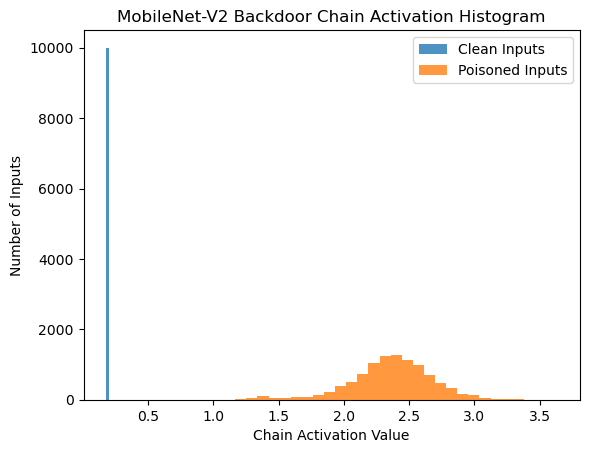

In [11]:
print(clean_output.mean(), poisoned_output.mean())

# Plot histogram
plt.hist(clean_output.squeeze(1).numpy(), bins=1, alpha=.8, label='Clean Inputs')
plt.hist(poisoned_output.squeeze(1).numpy(), bins=30, alpha=.8, label='Poisoned Inputs')

# plt.title("VGG-16 Backdoor Chain Activation Histogram")
# plt.title("ResNet-110 Backdoor Chain Activation Histogram")
plt.title("MobileNet-V2 Backdoor Chain Activation Histogram")
# plt.title("Wide-ResNet-40 Backdoor Chain Activation Histogram (Physical Realizable)")
plt.xlabel("Chain Activation Value")
plt.ylabel("Number of Inputs")
plt.legend()

plt.show()
# plt.savefig('cifar10-vgg16-backdoor-chain-activation-historgram.png')
# plt.savefig('cifar10-resnet110-backdoor-chain-activation-historgram.png')
# plt.savefig('cifar10-wideresnet40-backdoor-chain-activation-historgram.png')
# plt.savefig('cifar10-mobilenetv2-backdoor-chain-activation-historgram.png')